In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss

class EdgeLoss(nn.Module):
    def __init__(self):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1)
        if torch.cuda.is_available():
            self.kernel = self.kernel.to(DEVICE)
        self.loss = CharbonnierLoss()
        print(self.kernel)
        print(self.kernel.shape)

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        print(img.shape)
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)    # filter
        down        = filtered[:,:,::2,::2]               # downsample
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4                  # upsample
        filtered    = self.conv_gauss(new_filter) # filter
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = self.loss(self.laplacian_kernel(x), self.laplacian_kernel(y))

        return loss


In [36]:
edgeloss = EdgeLoss()

tensor([[[[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]]],


        [[[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]]],


        [[[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]]]])
torch.Size([3, 1, 5, 5])


#输入一张图片，看看卷积的效果。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(381, 383, 3)
tensor([[[[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]]],


        [[[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]]],


        [[[0.0025, 0.0125, 0.0200, 0.0125, 0.0025],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0200, 0.1000, 0.1600, 0.1000, 0.0200],
          [0.0125, 0.0625, 0.1000, 0.0625, 0.0125],
          [0.0025, 0.0125, 0.0200, 0.0125, 0.0025]]]])
torch.Size([3, 1, 5, 5])
torch.Size([3, 381, 383])
torch.Size([1, 3, 381, 383])
<class 'torch.Tensor'>
torch.Size([1, 3, 385, 387])
torch.Size([1, 3, 381, 383])
torch.Size([1, 3, 385, 387])
torch

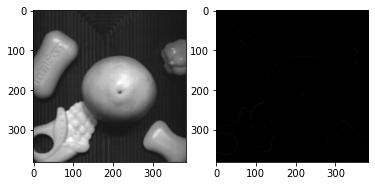

In [37]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

img_path = 'restored.png'
image = io.imread(img_path)
plt.subplot(1,2,1)
plt.imshow(image)
print(image.shape)

image = image.astype(np.float32)
edgeloss = EdgeLoss()
image_torch = torch.from_numpy(image)
image_t = image_torch.permute(2,0,1)
print(image_t.shape)
image_unsqueezed = image_t.unsqueeze(0)
print(image_unsqueezed.shape)
print(type(image_unsqueezed))

res = edgeloss.conv_gauss(image_unsqueezed)
print(res.shape)
lap_res = edgeloss.laplacian_kernel(image_unsqueezed)
imagesqueezed = lap_res.squeeze()
imagesqueezed = imagesqueezed.permute(1,2, 0)
imagesqueezed_Int = imagesqueezed.int()
plt.subplot(1,2,2)
plt.imshow(imagesqueezed_Int.numpy())